In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import fractional_matrix_power
from scipy.fftpack import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance_matrix
from sklearn import datasets
import pandas as pd

In [2]:
def diff_map(data, L):
    '''
    Calculates first L eigenvalues and eigenfunctions
    of Laplace Betrami operation on matrix data
    in decreasing order, omiting first eigenvalue and 
    eigenfunction. Implements steps from exercise sheet
    Using two validations to check correctness of results
    (describe in comments and report)
    Input:
        data - NxD matrix containing data
        L - number of eigenvalues and eigenfunctions to use
    Output:
        lambda_l - vector containing L eigenvalues
        psy_l - NxL matrix containing L eigenfunctions
    '''
    D = distance_matrix(data, data)
    eps = 0.05 * max(map(max, D))
    W = np.exp(-np.square(D) / eps)
    P = np.diag(np.sum(W, axis=1))
    K = np.matmul(np.linalg.inv(P), np.matmul(W, np.linalg.inv(P)))
    Q = np.diag(np.sum(K, axis=1))
    Q_pow = fractional_matrix_power(Q, -0.5)
    T_hat = np.matmul(np.matmul(Q_pow, K), Q_pow)
    a, v = np.linalg.eigh(T_hat)
    a_l = a[-(L+1):]
    v_l = v[:, -(L+1):]
    # omit last column, since it's constant
    lambda_l = np.power(a_l, (1/eps))[:-1]
    psy_l = np.matmul(Q_pow, v)[:, -(L+1):][:, :-1]
    # flip columns (to be in inceasing order of eigenvalues)
    lambda_l = np.flip(lambda_l)
    psy_l = np.flip(psy_l, axis=1)
    # T and T_hat should have same eigenvalues (T = Q ^ -0.5 * T_hat * Q ^ 0.5)
    T = np.matmul(np.matmul(Q_pow, T_hat), fractional_matrix_power(Q, 0.5))
    lambda_t, v_t = np.linalg.eigh(T)
    np.testing.assert_array_almost_equal(lambda_t, a, decimal=2)
    # T ^ 1/eps * psy_l = lambda_l * psy_l
    check_1 = np.dot(fractional_matrix_power(T, 1/eps), psy_l)
    check_2 = np.multiply(lambda_l, psy_l)
    np.testing.assert_array_almost_equal(check_1, check_2)
    return lambda_l, psy_l

# copied from 1st exercise (ex_1.ipynb)
def pca_projection(df, n_components):
    '''
    Projects data onto first n principal components in increasing order
    of eigenvalues and prints energy preserved
    Input:
        df - pandas dataframe containing 2D data
        n_components - number of principal components to use
    Output:
        proj - projection of df onto first n_components PCs
        v - right singular vectors transposed
    '''
    # subtract mean from data
    df = df - df.mean(axis=0)
    # SVD decomposition (in decreasing order of eigenvalues)
    u, s, v = np.linalg.svd(df, full_matrices=False)
    # calculate energy preserved in first n_components
    energy = np.round(np.sum(s[:n_components]) / np.sum(s) * 100, 2)
    print("Energy: ", energy, "%")
    # set eigenvalues of unused components to 0
    s[n_components:] = 0
    # compute projection of data onto PCs
    proj = u @ np.diag(s)
    return proj, v

def pca_2d_reconstruction(df, n_components):
    '''
    Performs PCA reconstruction of 2D data
    Input:
        df - pandas dataframe containing 2D data
        n_components - number of principal components to use
    Output:
        proj @ v - reconstructed data
    '''
    # get projection of data onto PCs, eigenvectors and energies
    proj, v = pca_projection(df, n_components)
    # calculate and return reconstruction and energy
    return proj @ v


# Part 1

In [3]:
# generate data points
N = 1000
L = 5
X = list()
t_ks = list()
for k in range(N):
    t_k = (2 * np.pi * k)/(N+1)
    cos_tk = math.cos(t_k)
    sin_tk = math.sin(t_k)
    entry =  [cos_tk, sin_tk]
    t_ks.append(t_k)
    X.append(entry)
X = np.array(X)
# get eigenvalues and eigenvectors
lambda_l, psy_l = diff_map(X, L)

### Original data

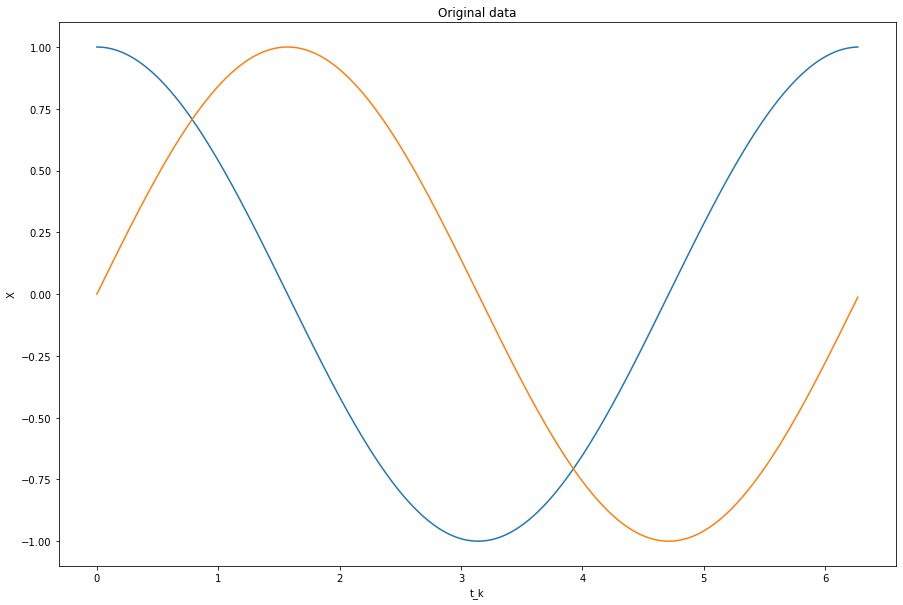

In [4]:
# plot original data
plt.figure(figsize=(15, 10))
plt.title("Original data")
plt.xlabel("t_k")
plt.ylabel("X")
plt.plot(t_ks, X)

### Diffusion map psy(x)

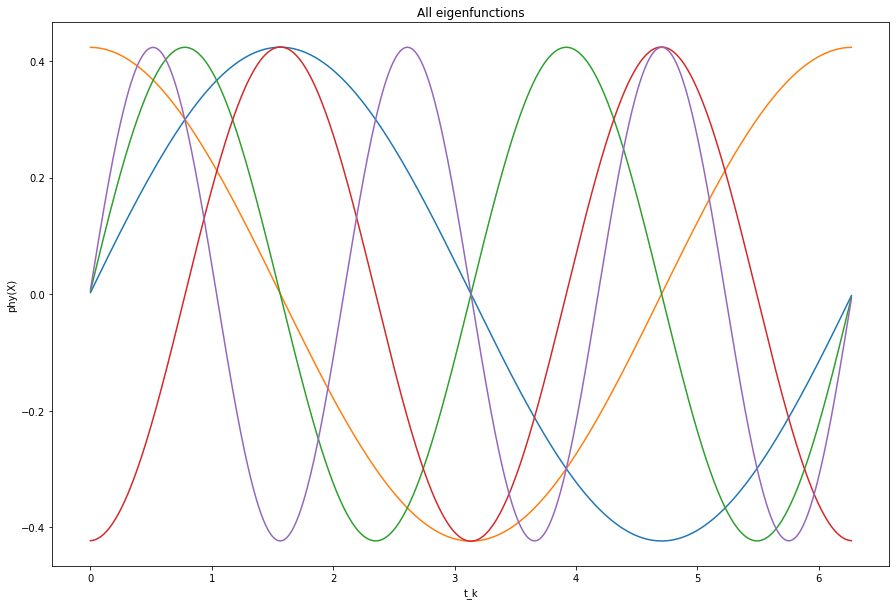

In [5]:
# plot all eigenvectors
plt.figure(figsize=(15, 10))
plt.title("All eigenfunctions")
plt.xlabel("t_k")
plt.ylabel("phy(X)")
plt.plot(t_ks, psy_l)

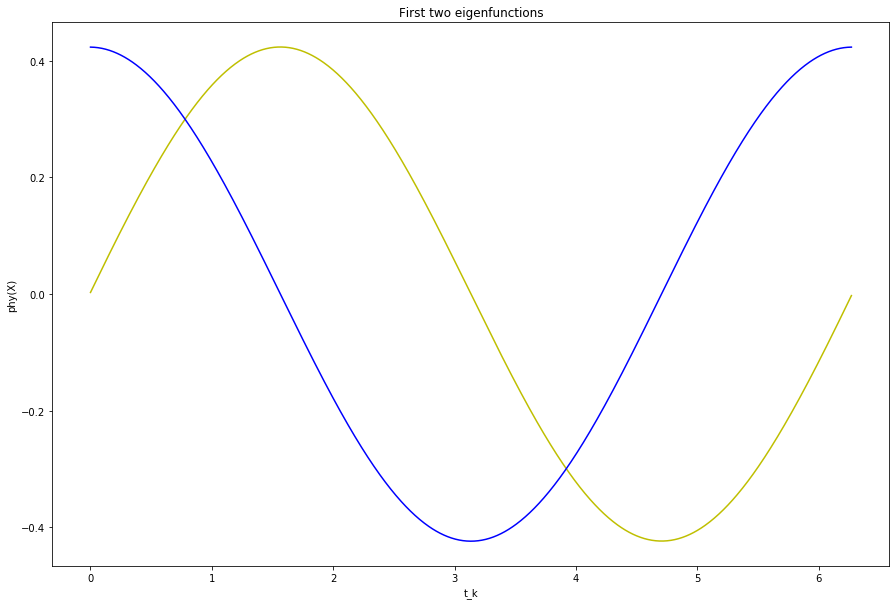

In [6]:
# plot first two eigenvectors
plt.figure(figsize=(15, 10))
plt.title("First two eigenfunctions")
plt.xlabel("t_k")
plt.ylabel("phy(X)")
plt.plot(t_ks, psy_l[:, 0], c='y')
plt.plot(t_ks, psy_l[:, 1], c='b')

### Fourier transform of data

D:\Anaconda\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


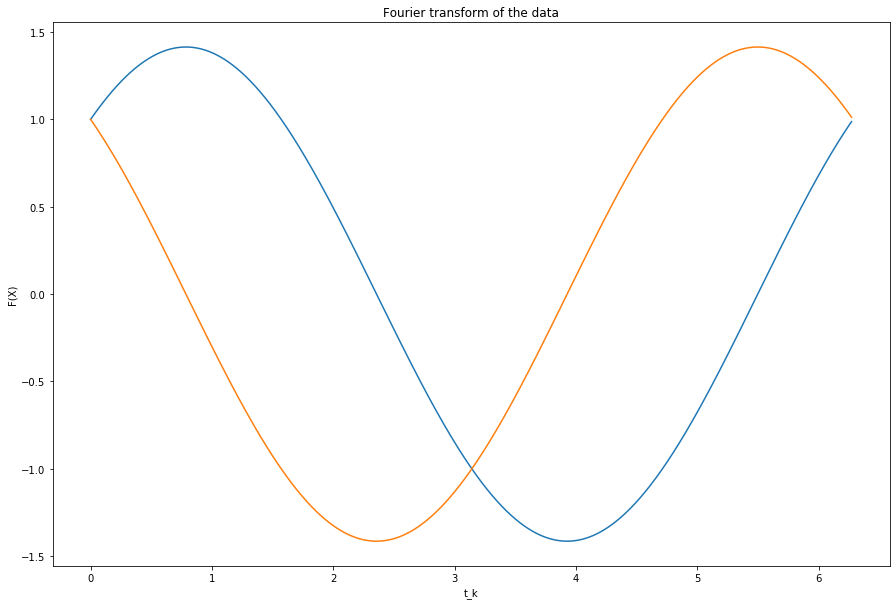

In [7]:
ft = fft(X)
# plot first two eigenvectors
plt.figure(figsize=(15, 10))
plt.title("Fourier transform of the data")
plt.xlabel("t_k")
plt.ylabel("F(X)")
plt.plot(t_ks, ft)

# Part 2

In [8]:
Axes3D

mpl_toolkits.mplot3d.axes3d.Axes3D

In [9]:
X, color = datasets.make_swiss_roll(n_samples=2000, noise=0, random_state=42)

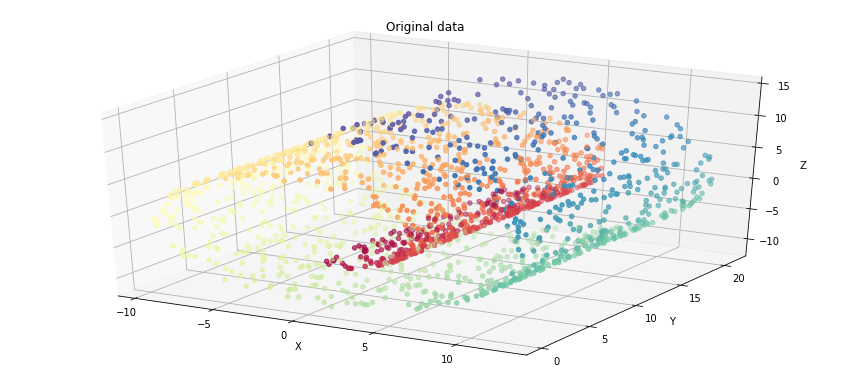

In [10]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Original data")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.axis('tight')
plt.show()

In [11]:
L = 10
lambda_l, psy_l = diff_map(X, L)

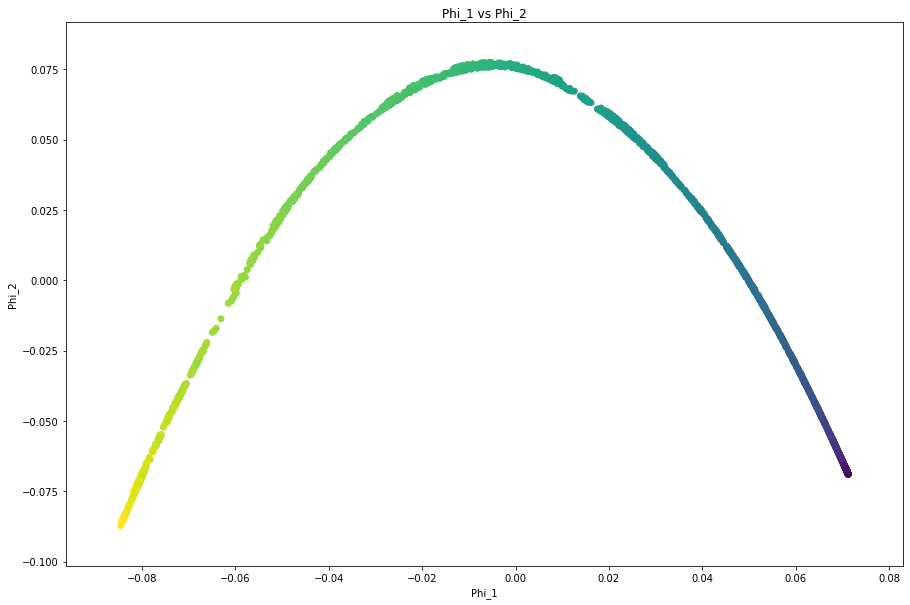

In [12]:
# psy1 vs psy2
fig = plt.figure(figsize=(15, 10))
plt.title("Phi_1 vs Phi_2")
plt.xlabel("Phi_1")
plt.ylabel("Phi_2")
plt.scatter(psy_l[:, 0], psy_l[:, 1], c=color)

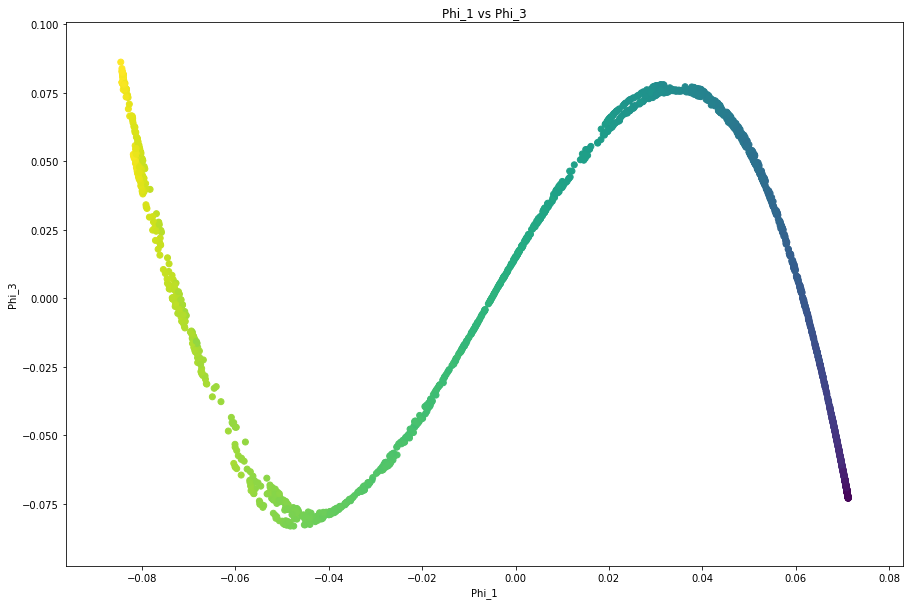

In [13]:
# psy1 vs psy3
fig = plt.figure(figsize=(15, 10))
plt.title("Phi_1 vs Phi_3")
plt.xlabel("Phi_1")
plt.ylabel("Phi_3")
plt.scatter(psy_l[:, 0], psy_l[:, 2], c=color)

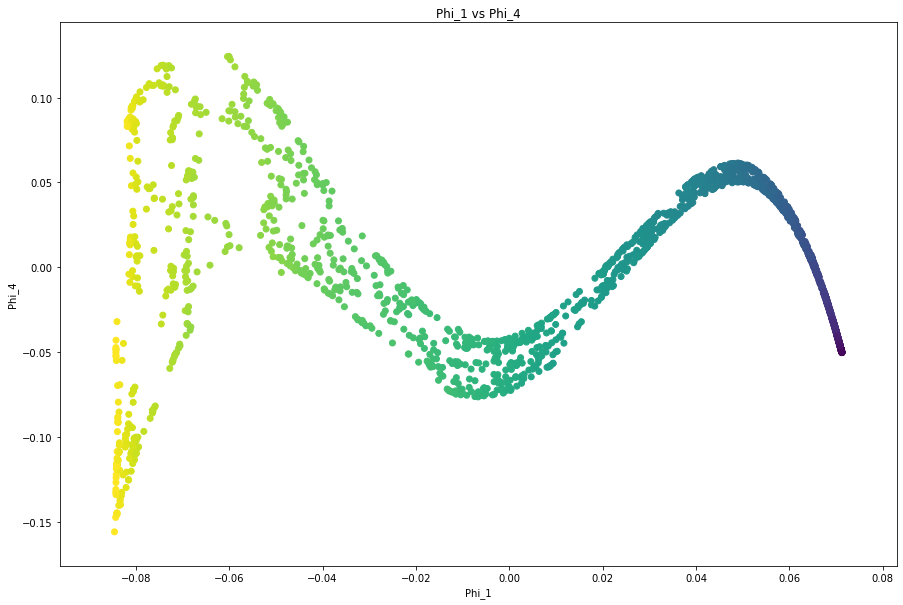

In [14]:
# psy1 vs psy4
fig = plt.figure(figsize=(15, 10))
plt.title("Phi_1 vs Phi_4")
plt.xlabel("Phi_1")
plt.ylabel("Phi_4")
plt.scatter(psy_l[:, 0], psy_l[:, 3], c=color)

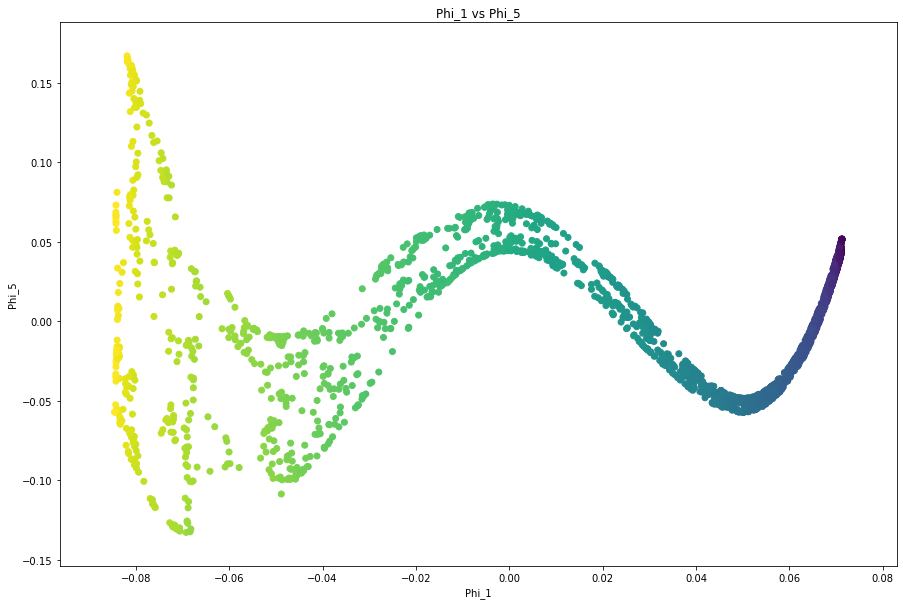

In [15]:
# psy1 vs psy5
fig = plt.figure(figsize=(15, 10))
plt.title("Phi_1 vs Phi_5")
plt.xlabel("Phi_1")
plt.ylabel("Phi_5")
plt.scatter(psy_l[:, 0], psy_l[:, 4], c=color)

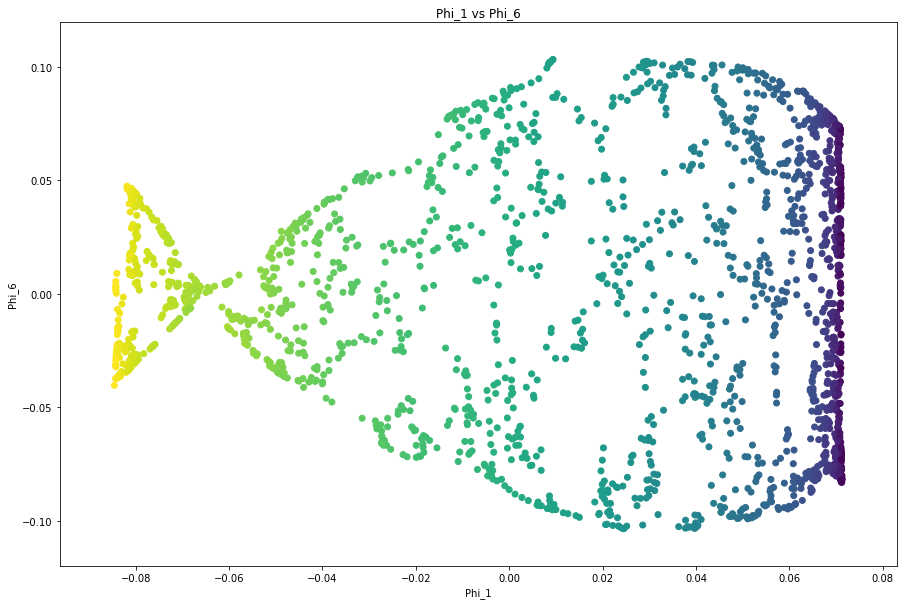

In [16]:
# psy1 vs psy6
fig = plt.figure(figsize=(15, 10))
plt.title("Phi_1 vs Phi_6")
plt.xlabel("Phi_1")
plt.ylabel("Phi_6")
plt.scatter(psy_l[:, 0], psy_l[:, 5], c=color)

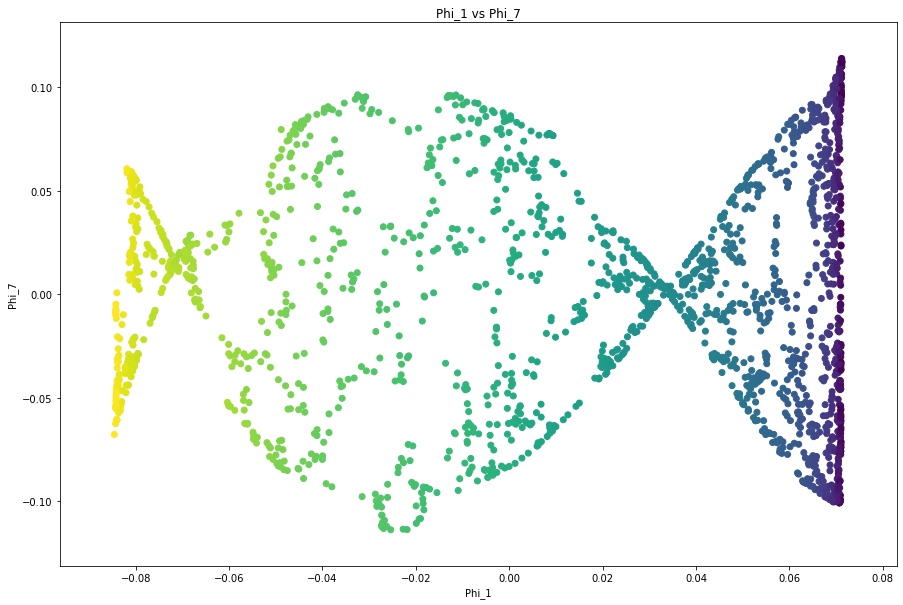

In [17]:
# psy1 vs psy7
fig = plt.figure(figsize=(15, 10))
plt.title("Phi_1 vs Phi_7")
plt.xlabel("Phi_1")
plt.ylabel("Phi_7")
plt.scatter(psy_l[:, 0], psy_l[:, 6], c=color)

### Using PCA

###### Reconstruction using PCA with 3 components

Energy:  100.0 %


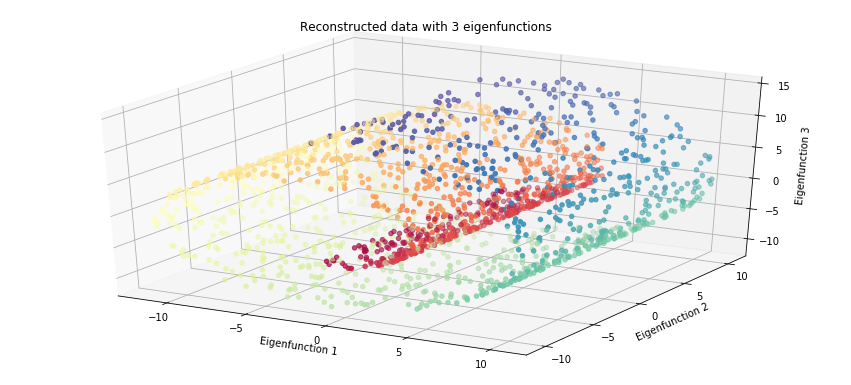

In [18]:
pca_X = pca_2d_reconstruction(X, 3)
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(pca_X[:, 0], pca_X[:, 1], pca_X[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Reconstructed data with 3 eigenfunctions")
ax.set_xlabel("Eigenfunction 1")
ax.set_ylabel("Eigenfunction 2")
ax.set_zlabel("Eigenfunction 3")
plt.axis('tight')
plt.show()

###### Reconstruction using PCA with 2 components on 3D plot

Energy:  69.13 %


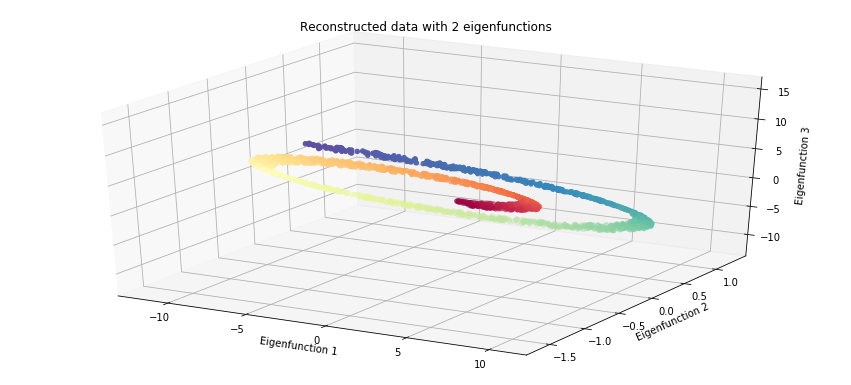

In [19]:
pca_X = pca_2d_reconstruction(X, 2)
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(pca_X[:, 0], pca_X[:, 1], pca_X[:, 2], c=color, cmap=plt.cm.Spectral)

ax.set_title("Reconstructed data with 2 eigenfunctions")
ax.set_xlabel("Eigenfunction 1")
ax.set_ylabel("Eigenfunction 2")
ax.set_zlabel("Eigenfunction 3")
plt.axis('tight')
plt.show()

###### Reconstruction using PCA with 2 components on 2D plot

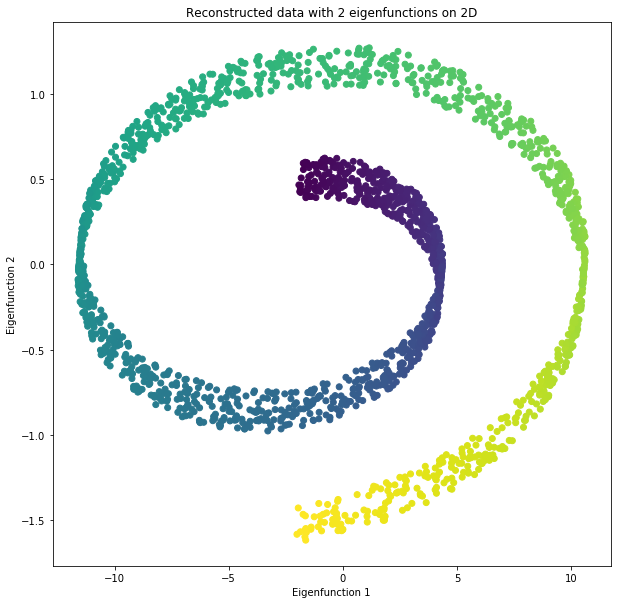

In [20]:
fig = plt.figure(figsize=(10, 10))
plt.title("Reconstructed data with 2 eigenfunctions on 2D")
plt.xlabel("Eigenfunction 1")
plt.ylabel("Eigenfunction 2")
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=color)

# Part 3

In [21]:
df = pd.read_csv('data_DMAP_PCA_vadere.txt', header=None, delimiter=' ')

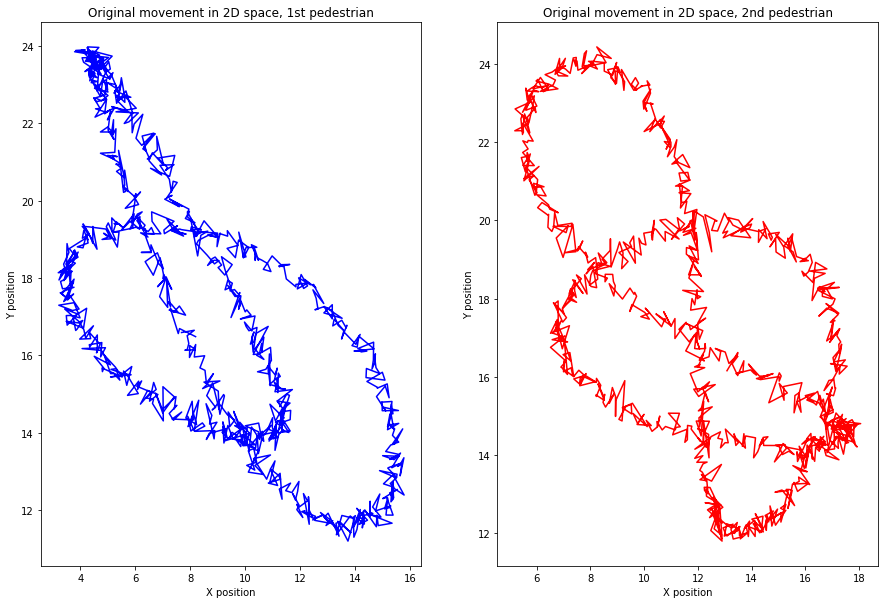

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.plot(df.iloc[:, 0], df.iloc[:, 1], color='b')
ax1.set_title("Original movement in 2D space, 1st pedestrian")
ax1.set_xlabel("X position")
ax1.set_ylabel("Y position")
ax2.plot(df.iloc[:, 2], df.iloc[:, 3], color='r')
ax2.set_title("Original movement in 2D space, 2nd pedestrian")
ax2.set_xlabel("X position")
ax2.set_ylabel("Y position")
plt.show()

In [23]:
L = 30
lambda_l, psy_l = diff_map(df, L)

In [24]:
# get projections onto eigenfunctions
proj_0 = np.dot(df, np.linalg.inv(df.T.dot(df)).dot(df.T.dot(psy_l[:, 0])))
proj_1 = np.dot(df, np.linalg.inv(df.T.dot(df)).dot(df.T.dot(psy_l[:, 1])))
proj_2 = np.dot(df, np.linalg.inv(df.T.dot(df)).dot(df.T.dot(psy_l[:, 2])))

Text(0, 0.5, 'Eigenfunction 2')

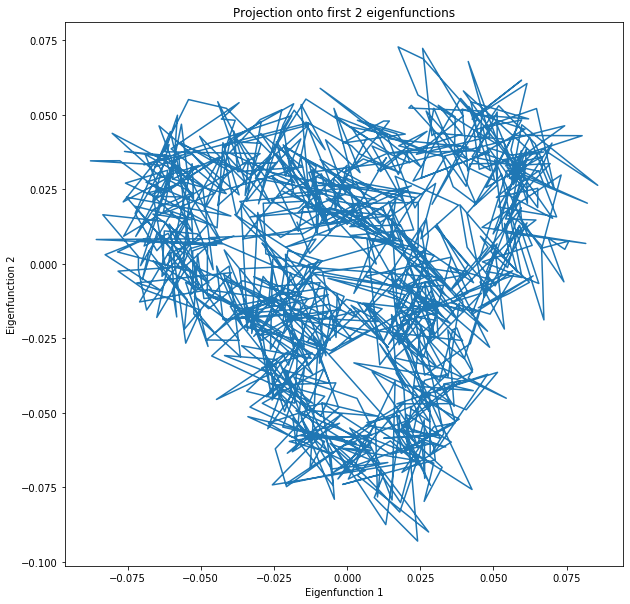

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(proj_0, proj_1)
plt.title("Projection onto first 2 eigenfunctions")
plt.xlabel("Eigenfunction 1")
plt.ylabel("Eigenfunction 2")

Text(0.5, 0, 'Eigenfunction 3')

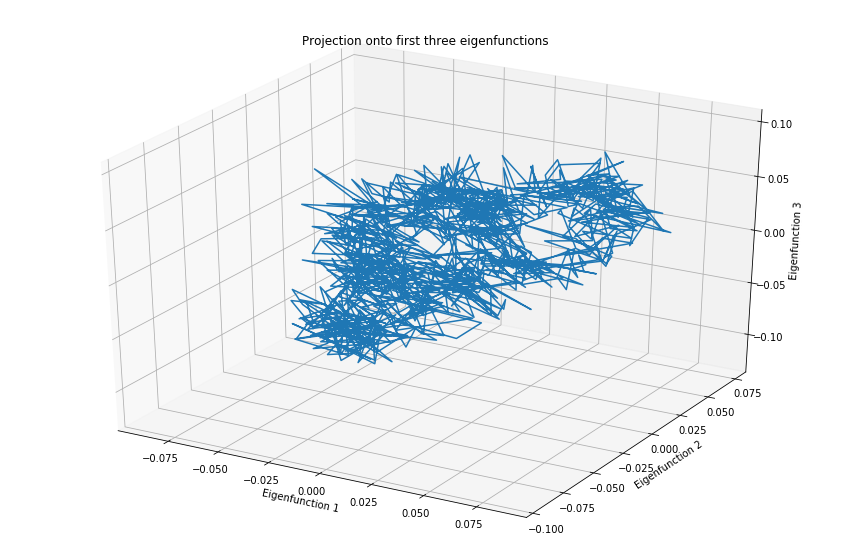

<Figure size 720x720 with 0 Axes>

In [26]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.figure(figsize=(10, 10))
ax.plot(proj_0, proj_1, proj_2)
ax.set_title("Projection onto first three eigenfunctions")
ax.set_xlabel("Eigenfunction 1")
ax.set_ylabel("Eigenfunction 2")
ax.set_zlabel("Eigenfunction 3")